## Work in progress

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# plotting settings
plt.rcParams["figure.dpi"] = 200
plt.rcParams["figure.figsize"] = (18, 6)

from toad_lab import TOAD, TOADPlotter

## 1.0—Init the TOAD object
Init toad ojbect with an xarray or .nc file


In [2]:
# Init the TOAD object with an xarray or .nc file
# td = TOAD("data/my_dataset.nc")

# Load file with pre-computed shifts
data = xr.open_dataset("../testing-data/garbe_2020_antarctica.nc").coarsen(x=2, y=2, time=2, boundary='trim').mean() # lower resolution to speed up cluster computation
td = TOAD(data)

In [3]:
# The TOAD object wraps the xarray datasets and provides analysis functions etc.
# You can always access the underlying xarray dataset with td.data
td.data

<xarray.Dataset> Size: 13MB
Dimensions:  (time: 175, y: 95, x: 95)
Coordinates:
  * time     (time) float64 1kB 501.0 1.301e+03 ... 1.389e+05 1.397e+05
  * x        (x) float64 760B -3.016e+06 -2.952e+06 ... 2.936e+06 3e+06
  * y        (y) float64 760B -3.016e+06 -2.952e+06 ... 2.936e+06 3e+06
    lat      (y, x) float64 72kB -52.13 -52.5 -52.87 ... -53.06 -52.69 -52.32
    lon      (y, x) float64 72kB -135.0 -135.6 -136.2 ... 43.75 44.38 45.0
Data variables:
    thk      (time, y, x) float32 6MB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    thk_dts  (time, y, x) float32 6MB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes: (12/13)
    CDI:            Climate Data Interface version 1.9.6 (http://mpimet.mpg.d...
    proj4:          +lon_0=0.0 +ellps=WGS84 +datum=WGS84 +lat_ts=-71.0 +proj=...
    CDO:            Climate Data Operators version 1.9.6 (http://mpimet.mpg.d...
    source:         PISM (development v1.0-535-gb3de48787 committed by Julius...
    institution:    PIK / Potsdam Institute for Climate Impact Research
    author:         Julius Garbe (julius.garbe@pik-potsdam.de)
    ...             ...
    title:          Antarctic ice thickness evolution for the quasi-static re...
    Conventions:    CF-1.9
    projection:     Polar Stereographic South (71S,0E)
    ice_density:    910. kg m-3
    NCO:            netCDF Operators version 4.7.8 (Homepage = http://nco.sf....
    Modifications:  Modified by Jakob Harteg (jakob.harteg@pik-potsdam.de) No...

## 1.1 — Preprocessing
Run preprocessing checks:
- Nothing implemented yet...

In [4]:
# td.preprocess()...

## 1.2 — Compute shifts
Computing shifts means running the algorithm that detects how fast the time series in each variable changes, but TOAD will allow for a broader range of methods

Under the hood, TOAD creates a new variable in the data frame called `{var}_dts` for a variable called `{var}`

In [5]:
from toad_lab.shifts_detection.methods import ASDETECT


# Minimum required input is a variable name and method
td.compute_shifts("thk", method=ASDETECT())

# All options:
# shifts = td.compute_shifts(
#     var="thk",
#     method=ASDETECT(        # default method
#         lmin=5,             # minimum length of segments
#         lmax=None,          # maximum length of segments
#     ),
#     temporal_dim="time",    # time dimension
#     output_label="my_shifts", # changes the name of the new variable
#     return_results_directly=True, # if you don't want to merge the result with the original 
# )

You can write your own shifts detection methods by subclassing the base class in `toad_lab.shifts_detection.methods.base`. See the example `examples/shifts_detection_methods.ipynb` for more info.

## 1.3—Compute clusters

In [6]:
from toad_lab.clustering.methods import HDBSCAN


# Minimum required input is a variable name, a method and a filtering function. 
td.compute_clusters(
    var='thk',                                  # toad will find computed shifts for this variable
    method=HDBSCAN(min_cluster_size=25),        
    shifts_filter_func=lambda x: np.abs(x)>0.8, # toad will cluster the points that pass this filter
)

# # All options:
# clusters = td.compute_clusters(
#     var='thk',    
#     method=HDBSCAN( # HDBSCAN also has various params
#         min_cluster_size=10,
#         min_samples=None,                
#         cluster_selection_epsilon=0.0,   
#         metric="euclidean",              
#     ),
#     shifts_label="thk_dts", # if you had named your shifts variable differently, pass it in here
#     shifts_filter_func=lambda x: np.abs(x)>0.8,
#     var_filter_func=lambda x: x > 1,
#     output_label="my_clusters",
#     return_results_directly=True, # if you don't want to merge the result with the original 
# );

You can write your own clustering methods by subclassing the base class in `toad_lab.clustering.methods.base`. See the example `examples/clustering_methods.ipynb` for more info.

## 1.4 — Postprocessing

By default, results from shifts and cluster computations are merged into the original dataset (td.data). While you can access everything directly, TOAD provides helper functions to easily extract insights from the results.

In [7]:
td.data

<xarray.Dataset> Size: 25MB
Dimensions:      (time: 175, y: 95, x: 95)
Coordinates:
  * time         (time) float64 1kB 501.0 1.301e+03 ... 1.389e+05 1.397e+05
  * x            (x) float64 760B -3.016e+06 -2.952e+06 ... 2.936e+06 3e+06
  * y            (y) float64 760B -3.016e+06 -2.952e+06 ... 2.936e+06 3e+06
    lat          (y, x) float64 72kB -52.13 -52.5 -52.87 ... -52.69 -52.32
    lon          (y, x) float64 72kB -135.0 -135.6 -136.2 ... 43.75 44.38 45.0
Data variables:
    thk          (time, y, x) float32 6MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    thk_dts      (time, y, x) float32 6MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    thk_cluster  (time, y, x) int64 13MB -1 -1 -1 -1 -1 -1 ... -1 -1 -1 -1 -1 -1
Attributes: (12/13)
    CDI:            Climate Data Interface version 1.9.6 (http://mpimet.mpg.d...
    proj4:          +lon_0=0.0 +ellps=WGS84 +datum=WGS84 +lat_ts=-71.0 +proj=...
    CDO:            Climate Data Operators version 1.9.6 (http://mpimet.mpg.d...
    source:         PISM (development v1.0-535-gb3de48787 committed by Julius...
    institution:    PIK / Potsdam Institute for Climate Impact Research
    author:         Julius Garbe (julius.garbe@pik-potsdam.de)
    ...             ...
    title:          Antarctic ice thickness evolution for the quasi-static re...
    Conventions:    CF-1.9
    projection:     Polar Stereographic South (71S,0E)
    ice_density:    910. kg m-3
    NCO:            netCDF Operators version 4.7.8 (Homepage = http://nco.sf....
    Modifications:  Modified by Jakob Harteg (jakob.harteg@pik-potsdam.de) No...

In [8]:
# Easily get shifts and clusters
shifts = td.get_shifts("thk")
clusters = td.get_clusters("thk")

In [9]:
# Get a list of identified clusters sorted by number of cells in each cluster
# -1 = unclustered cells
td.get_cluster_counts('thk', sort=True)

{-1: 6661,
 20: 908,
 17: 521,
 15: 316,
 16: 228,
 13: 128,
 19: 36,
 4: 35,
 1: 27,
 11: 24,
 18: 21,
 0: 19,
 8: 19,
 6: 15,
 14: 14,
 10: 11,
 21: 11,
 22: 9,
 12: 8,
 9: 5,
 7: 4,
 2: 3,
 3: 3,
 5: 3}

In [10]:
# short hand for getting just the ids of the (sorted) clusters
td.get_cluster_ids('thk', sort=True)

[-1,
 20,
 17,
 15,
 16,
 13,
 19,
 4,
 1,
 11,
 18,
 0,
 8,
 6,
 14,
 10,
 21,
 22,
 12,
 9,
 7,
 2,
 3,
 5]

In [11]:
# Parameters used for shift computation are saved as attrs
td.get_shifts("thk").attrs  # or directly td.data.thk_dts.attrs

{'temporal_dim': 'time',
 'method': 'ASDETECT',
 'method_param_lmin': '5',
 'method_param_lmax': '',
 'git_version': '0.2'}

In [12]:
# Parameters used for clustering computation are saved as attrs
td.get_clusters("thk").attrs # or directly td.data.thk_cluster.attrs

{'clusters': array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20, 21, 22]),
 'var_filter_func': 'None',
 'shifts_filter_func': '    shifts_filter_func=lambda x: np.abs(x)>0.8, # toad will cluster the points that pass this filter\n',
 'scaler': 'StandardScaler',
 'method': 'HDBSCAN',
 'method_param_min_cluster_size': '25',
 'method_param_min_samples': '',
 'method_param_metric': 'euclidean',
 'method_param_cluster_selection_epsilon': '0.0',
 'git_version': '0.2'}

<xarray.Dataset> Size: 4kB
Dimensions:      (time: 175)
Coordinates:
  * time         (time) float64 1kB 501.0 1.301e+03 ... 1.389e+05 1.397e+05
    lat          float64 8B -67.09
    lon          float64 8B 120.7
    cell_xy      object 8B (2168000.0, -1288000.0)
    x            float64 8B 2.168e+06
    y            float64 8B -1.288e+06
Data variables:
    thk          (time) float32 700B 380.5 378.0 372.9 ... 0.000797 0.000797
    thk_dts      (time) float32 700B -0.08259 -0.154 -0.2634 ... 0.0 0.0 0.0
    thk_cluster  (time) float64 1kB -1.0 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0 -1.0
Attributes: (12/13)
    CDI:            Climate Data Interface version 1.9.6 (http://mpimet.mpg.d...
    proj4:          +lon_0=0.0 +ellps=WGS84 +datum=WGS84 +lat_ts=-71.0 +proj=...
    CDO:            Climate Data Operators version 1.9.6 (http://mpimet.mpg.d...
    source:         PISM (development v1.0-535-gb3de48787 committed by Julius...
    institution:    PIK / Potsdam Institute for Climate Impact Research
    author:         Julius Garbe (julius.garbe@pik-potsdam.de)
    ...             ...
    title:          Antarctic ice thickness evolution for the quasi-static re...
    Conventions:    CF-1.9
    projection:     Polar Stereographic South (71S,0E)
    ice_density:    910. kg m-3
    NCO:            netCDF Operators version 4.7.8 (Homepage = http://nco.sf....
    Modifications:  Modified by Jakob Harteg (jakob.harteg@pik-potsdam.de) No...

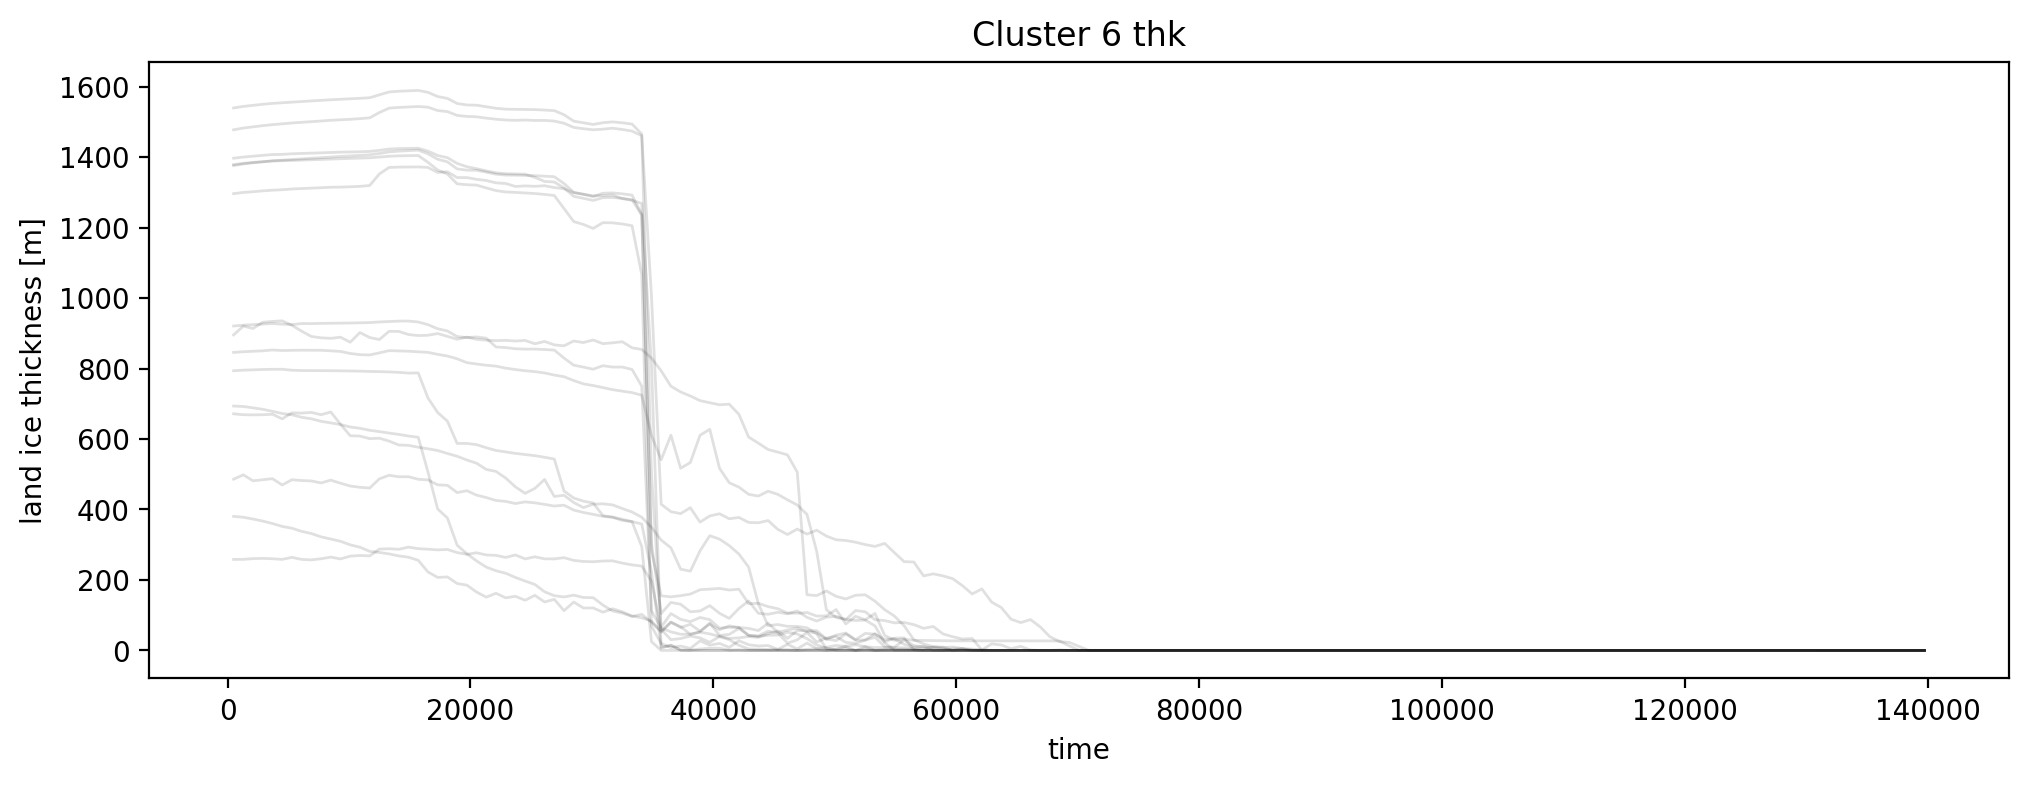

In [13]:

# Get data for all cells in a particular cluster
cluster_id = 6
cell_in_cluster = td.get_cluster_cell_data("thk", cluster_id=cluster_id)

# plot time series of thk from each cell
fig, ax = plt.subplots(figsize=(12,4))
for cell in cell_in_cluster:
    cell.thk.plot(ax=ax, color='k', alpha=0.12, lw=1)
ax.set_title(f"Cluster {cluster_id} thk")

# print data frame for first cell
cell_in_cluster[0]

### 1.4.1—Stats
Calling `td.stats()` will expose more statistics related helper functions.

In [14]:
# compute a rough cluster score giving a value close to 1 if the mean 
# cluster time series resembles a heavy-side function. 
td.stats().compute_cluster_score('thk', cluster_id=6)

0.25404665830171635

Text(0.5, 1.0, 'Mean values')

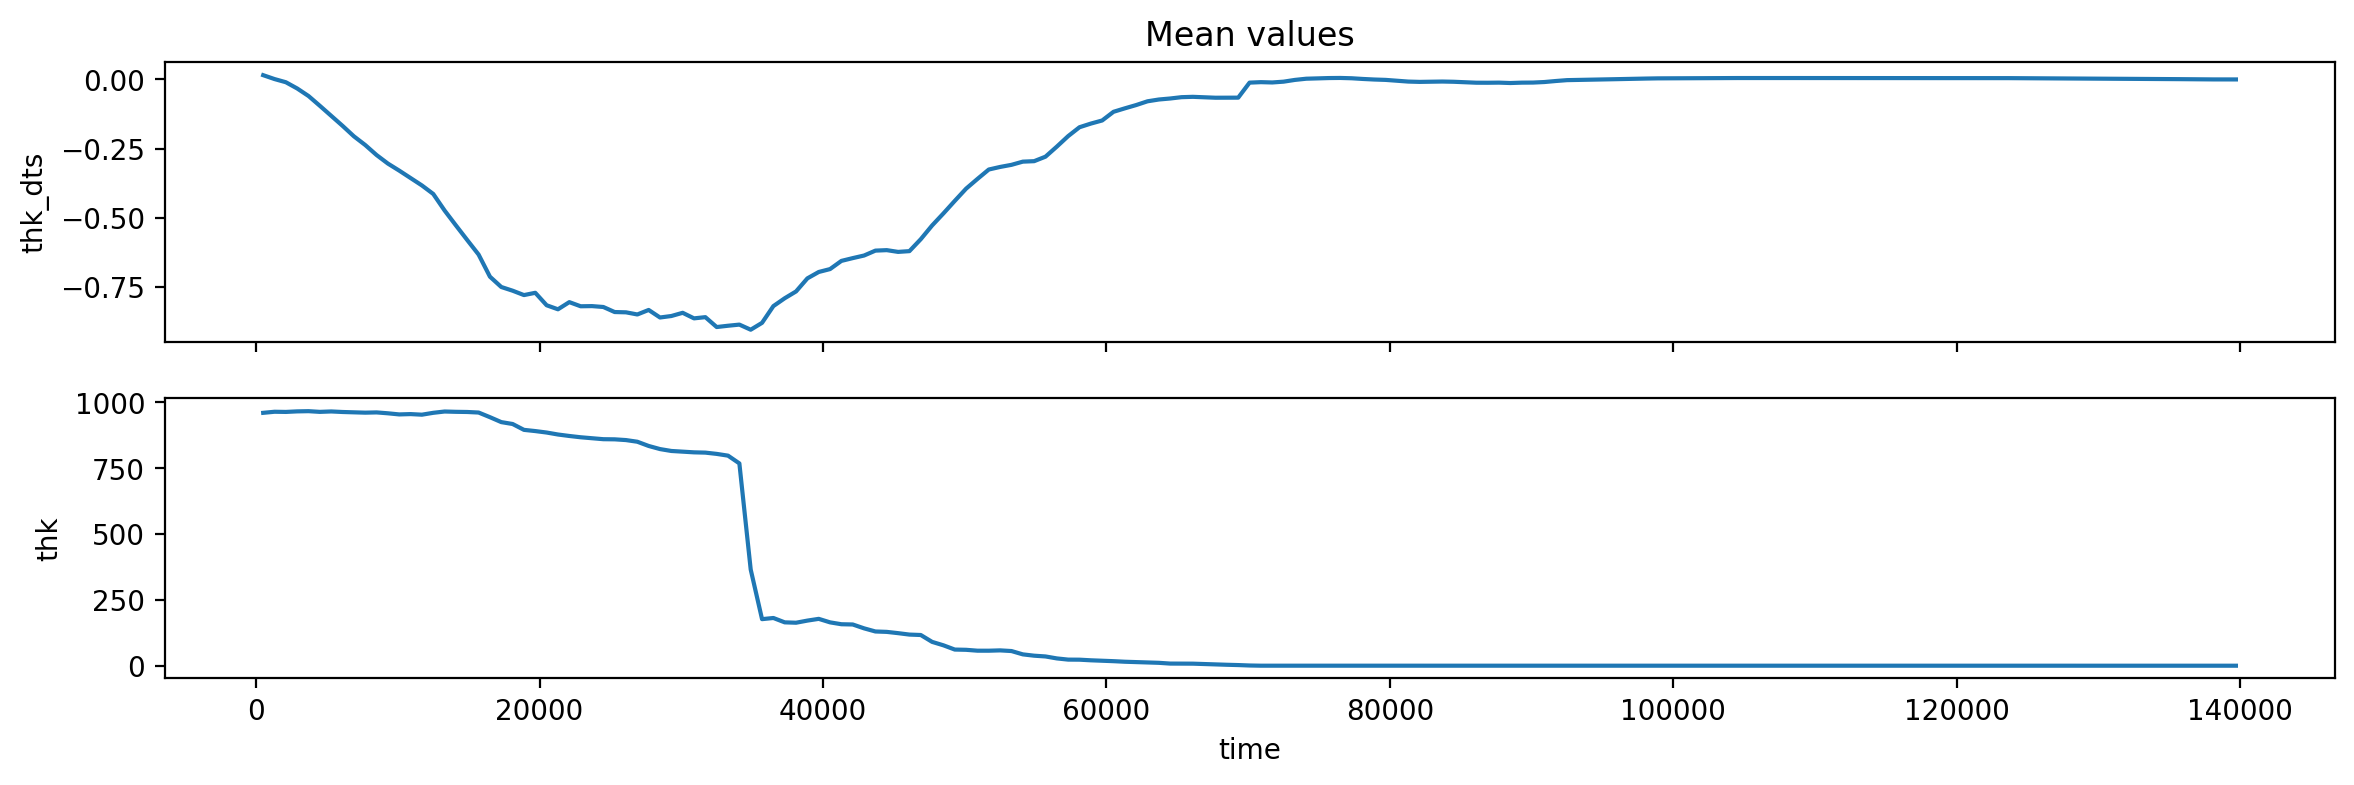

In [15]:
c = td.stats().get_cluster_cell_aggregate('thk', cluster_id=6, how='mean')
fig, axs = plt.subplots(2,1, figsize=(14,4), sharex=True)
c.thk_dts.plot(ax=axs[0])
c.thk.plot(ax=axs[1])
axs[0].set_xlabel("")
axs[0].set_title("Mean values")

## 1.5 — Plotting
**(In dev: These functions are very likely to change in the future)**

The `TOADPlotter` class provides a few simple plotting functions.

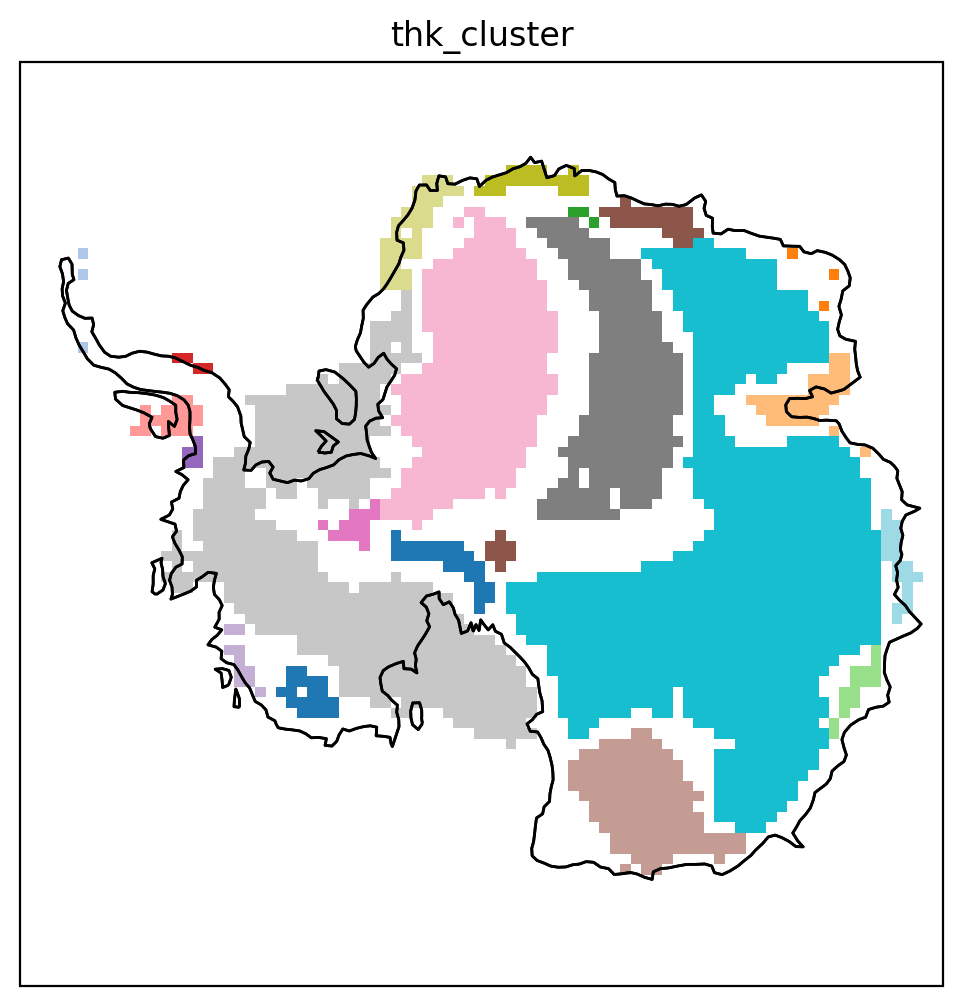

In [19]:
fig, ax = td.plotter().south_pole_plots(grid_labels=False)
TOADPlotter(td).plot_clusters_on_map("thk", ax=ax);

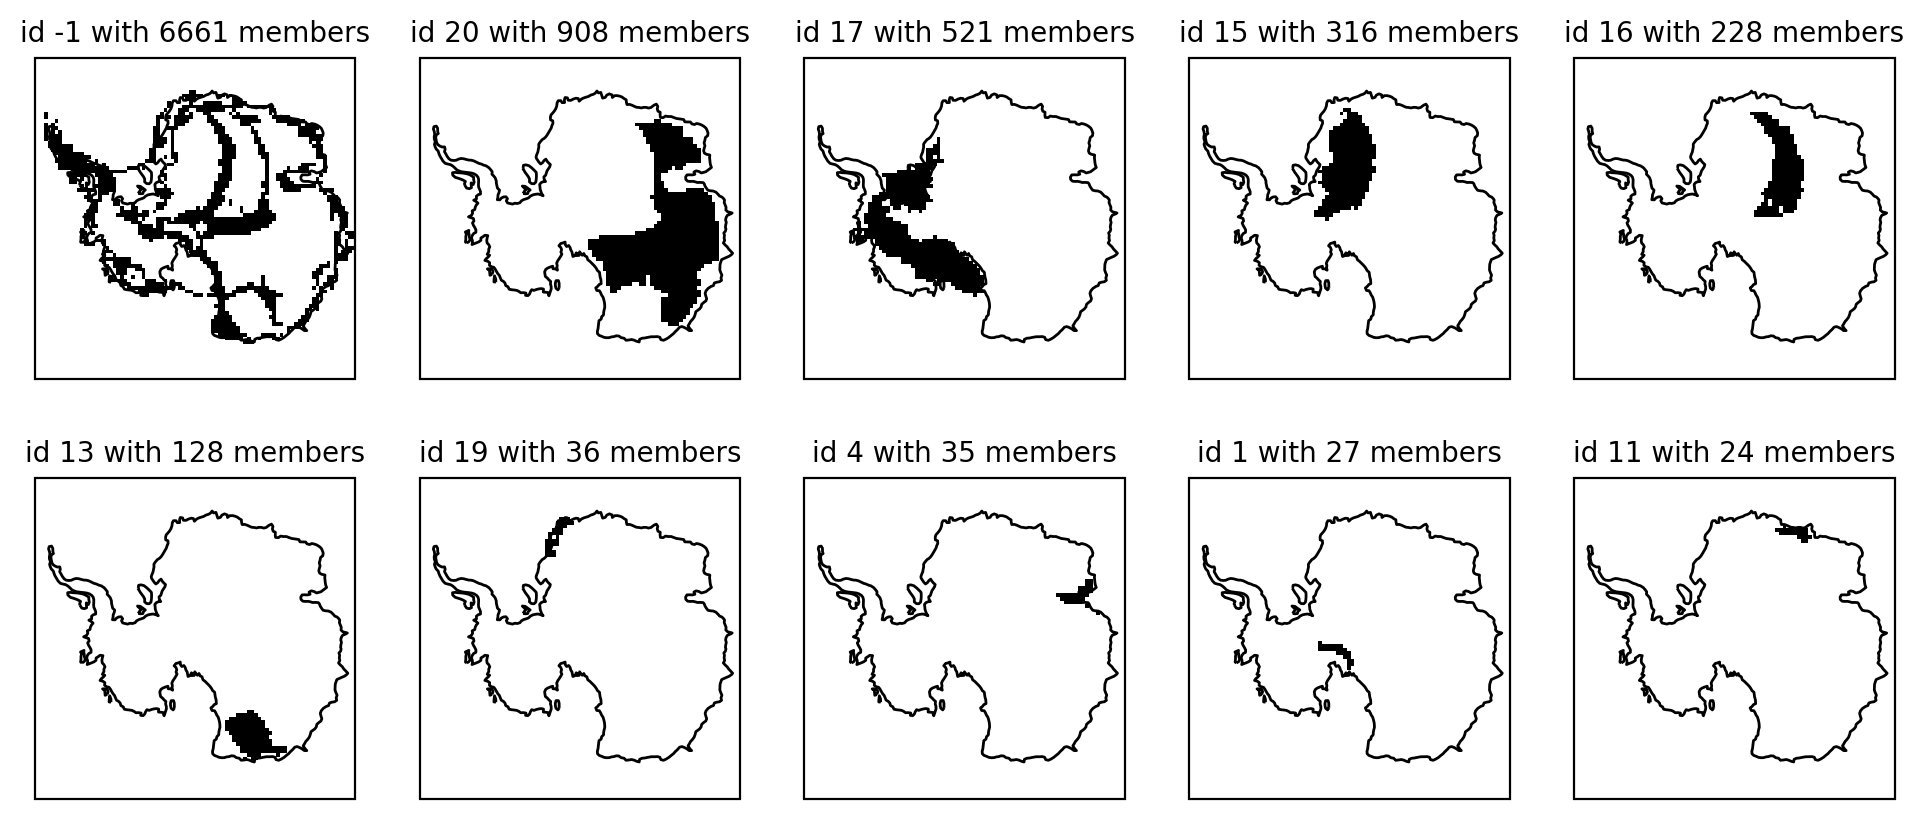

In [95]:
TOADPlotter(td).plot_clusters_on_maps('thk', max_clusters=10, south_pole=True)

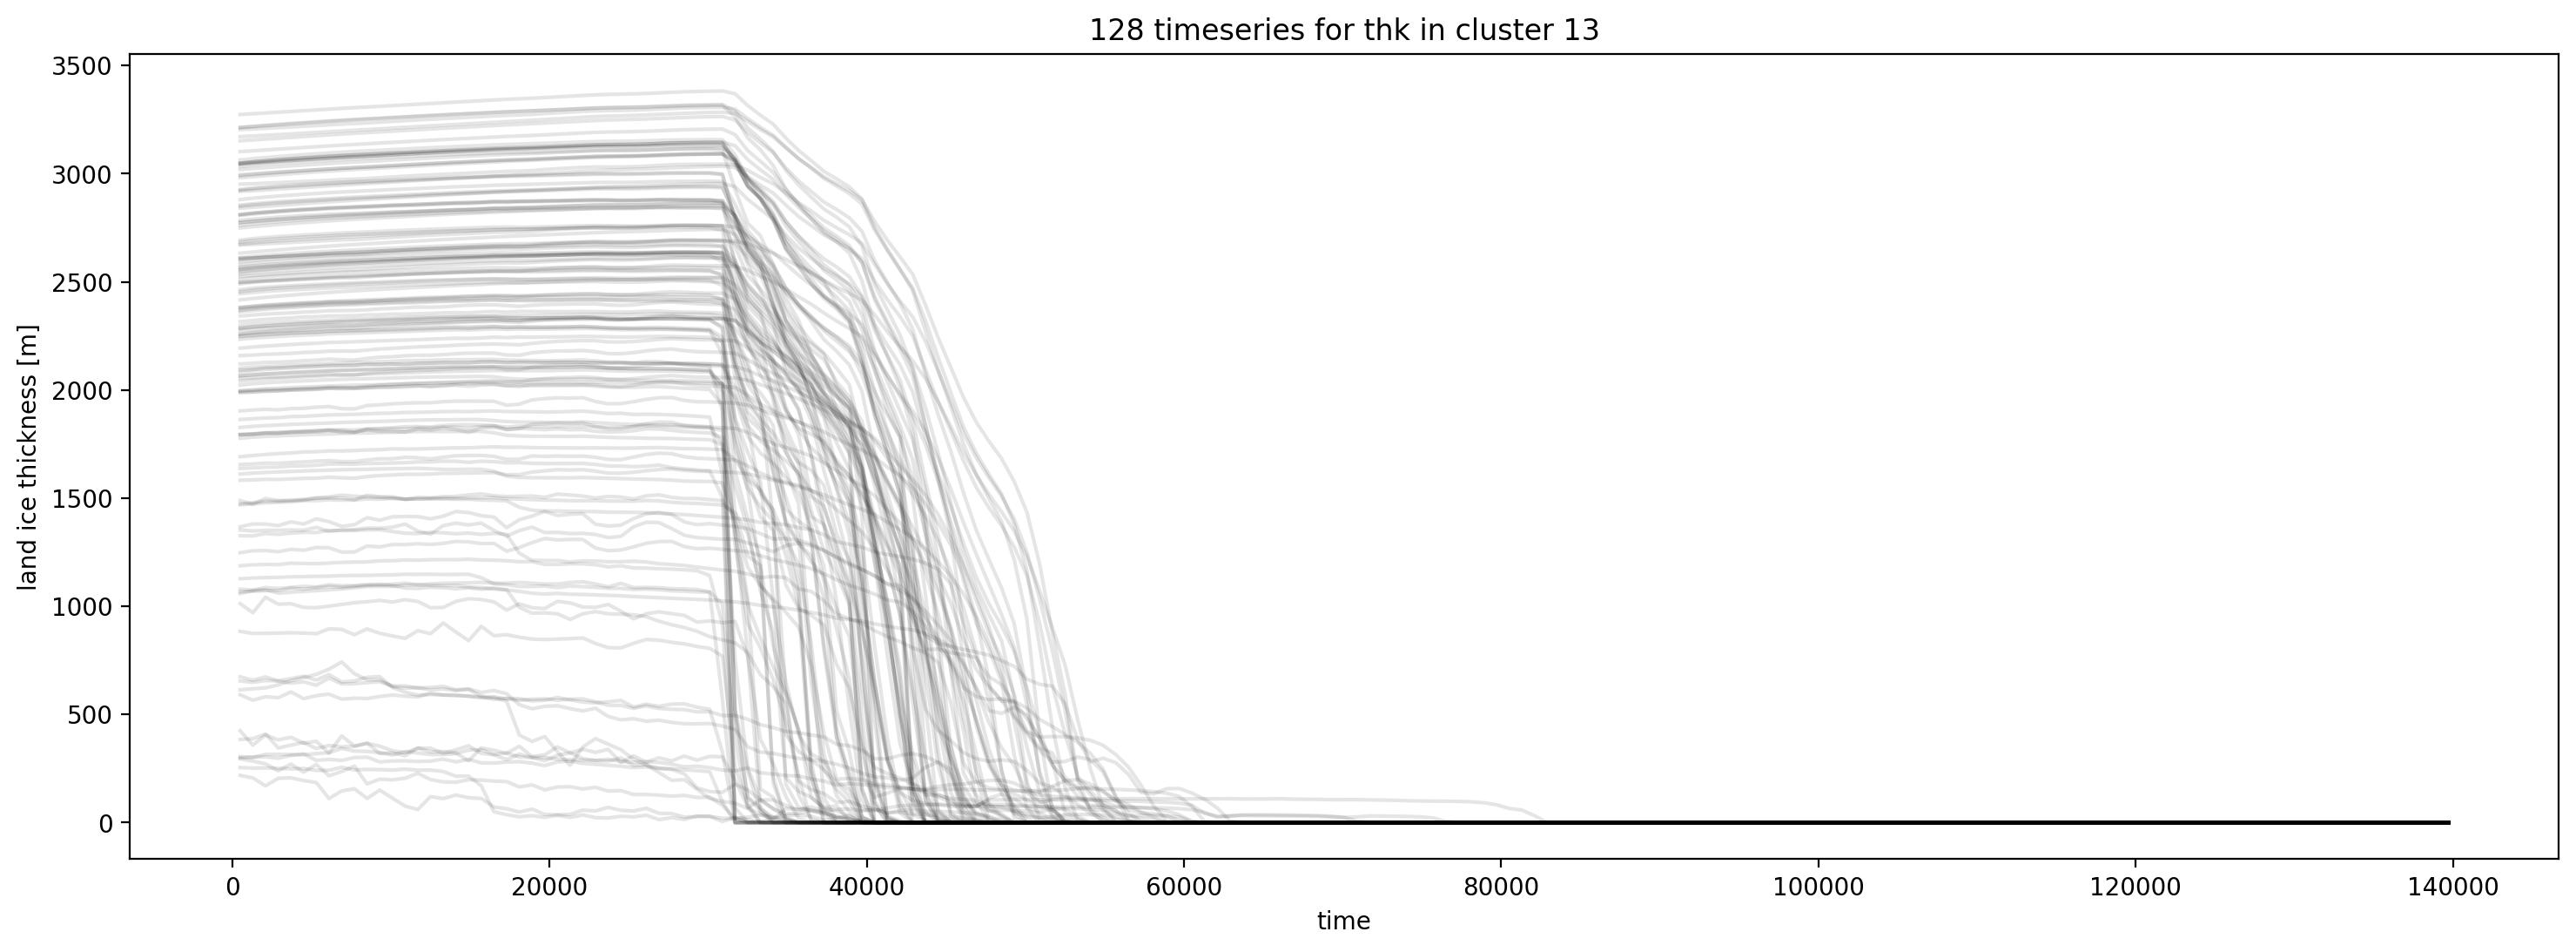

In [71]:
TOADPlotter(td).plot_cluster_time_series("thk", 13, color="black", alpha=0.1);

Text(0.5, 1.0, '100 timeseries from each of the 5 largest clusters')

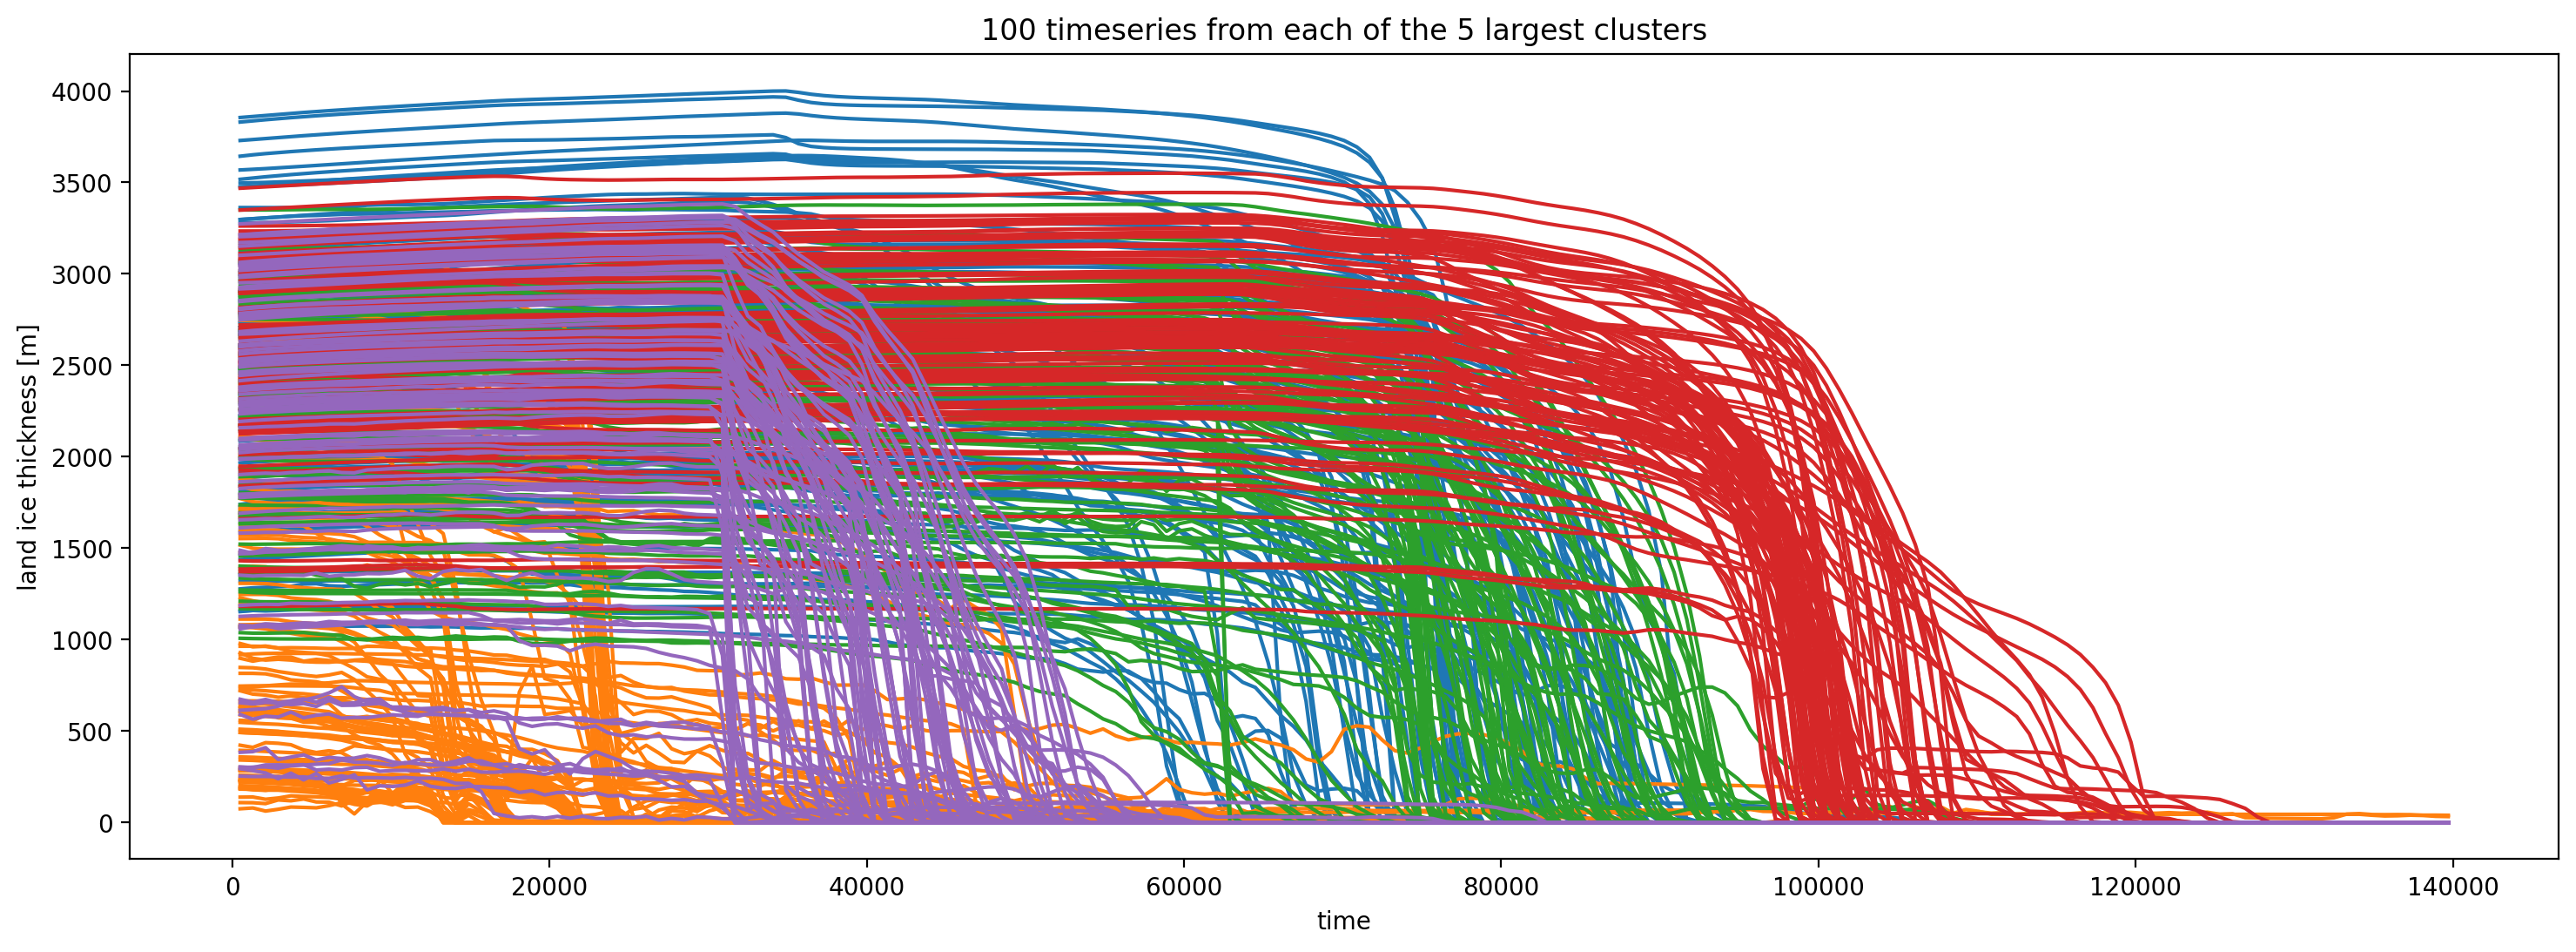

In [72]:
fig, ax = plt.subplots()
colors = plt.cm.tab10(np.linspace(0, 1, 10))
for i, id in enumerate(td.get_cluster_ids('thk', sort=True)[1:6]): # skip -1 (unclustered cells)
    TOADPlotter(td).plot_cluster_time_series("thk", id, color=colors[i], max_trajectories=100, ax=ax);
ax.set_title("100 timeseries from each of the 5 largest clusters")

Text(0.5, 1.0, 'Mean ± std for [8, 12, 5, 2, 14]')

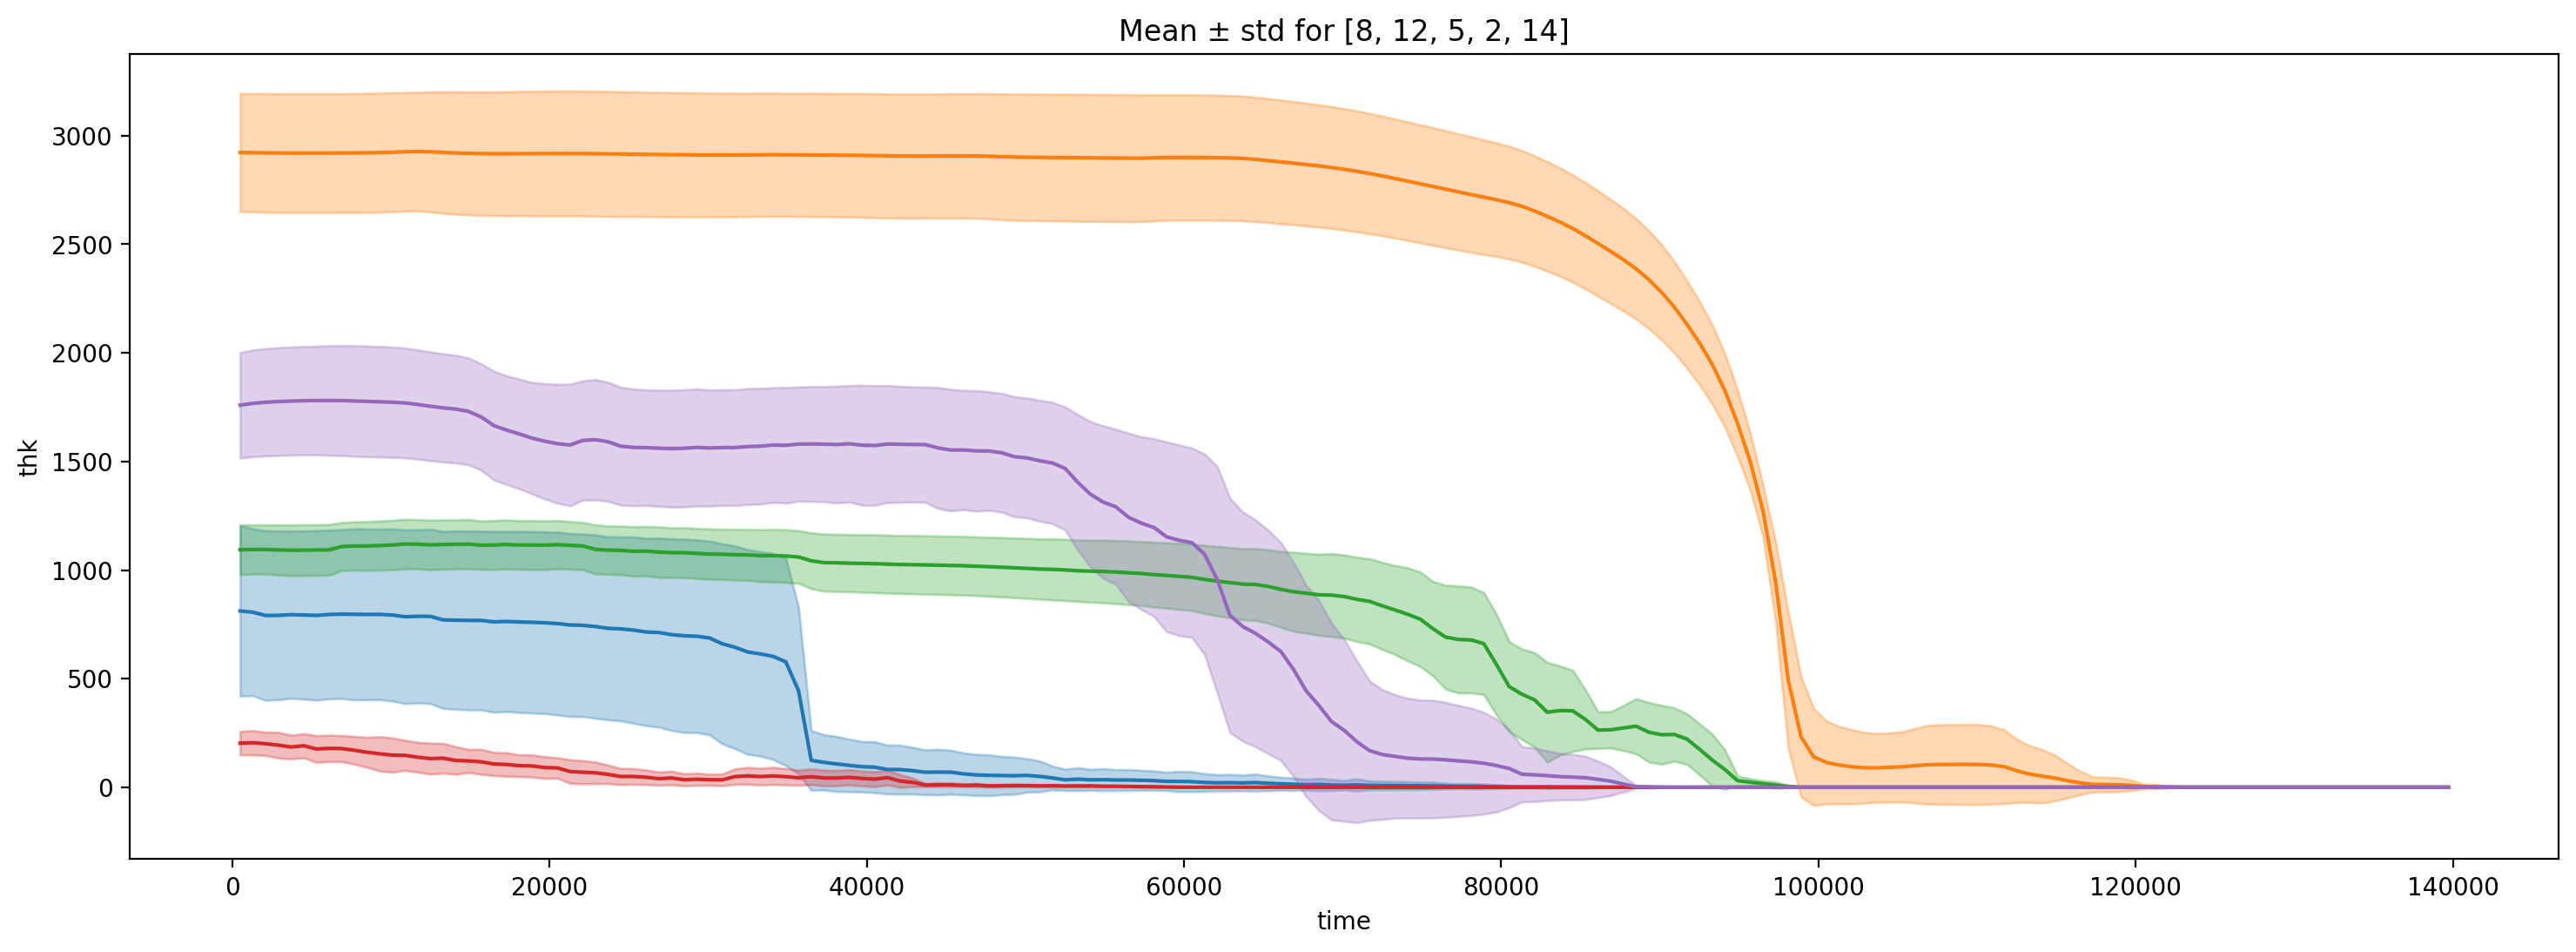

In [73]:
fig, ax = plt.subplots()
colors = plt.cm.tab10(np.linspace(0, 1, 10))
cluster_ids = [8, 12, 5, 2, 14]
for i, id in enumerate(cluster_ids):
    mean = td.stats().get_cluster_cell_aggregate("thk", id, how="mean")
    std = td.stats().get_cluster_cell_aggregate("thk", id, how="std").thk.values
    mean.thk.plot(ax=ax, color=colors[i])
    ax.fill_between(mean.time, mean.thk-std, mean.thk+std, color=colors[i], alpha=0.3)
ax.set_title(f"Mean ± std for {cluster_ids}")

# Example 2
Let's just try some different data: Mean summer near-surface air temperature

In [74]:
# Dataset contains pre-computed shifts
data = xr.load_dataset("../testing-data/global_mean_summer_tas.nc")

# To test computing shifts, we can lower the resolution
# data = data.coarsen(lat=7, lon=7, boundary='trim').mean()

td = TOAD(data)
# td.datab

In [75]:
from toad_lab.shifts_detection.methods import ASDETECT

td.compute_shifts("tas", method=ASDETECT()) 
# for coarsen(lat=7, lon=7) this takes 12 seconds on my laptop

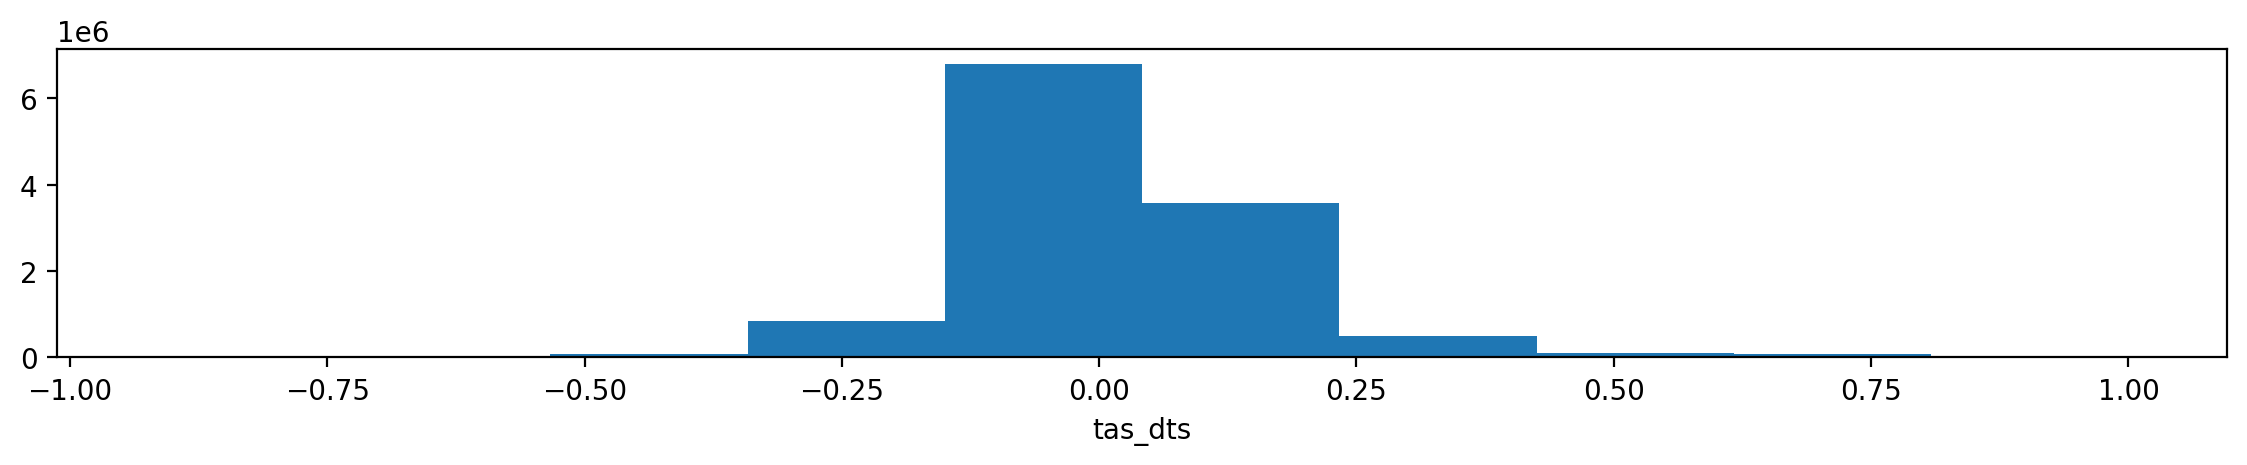

In [76]:
# Let's look at the shifts
td.get_shifts("tas").plot(figsize=(14,2));

In [77]:
from toad_lab.clustering.methods import HDBSCAN

td.compute_clusters("tas", shifts_filter_func=lambda x: np.abs(x)>0.5, method=HDBSCAN(min_cluster_size=40), overwrite=True)

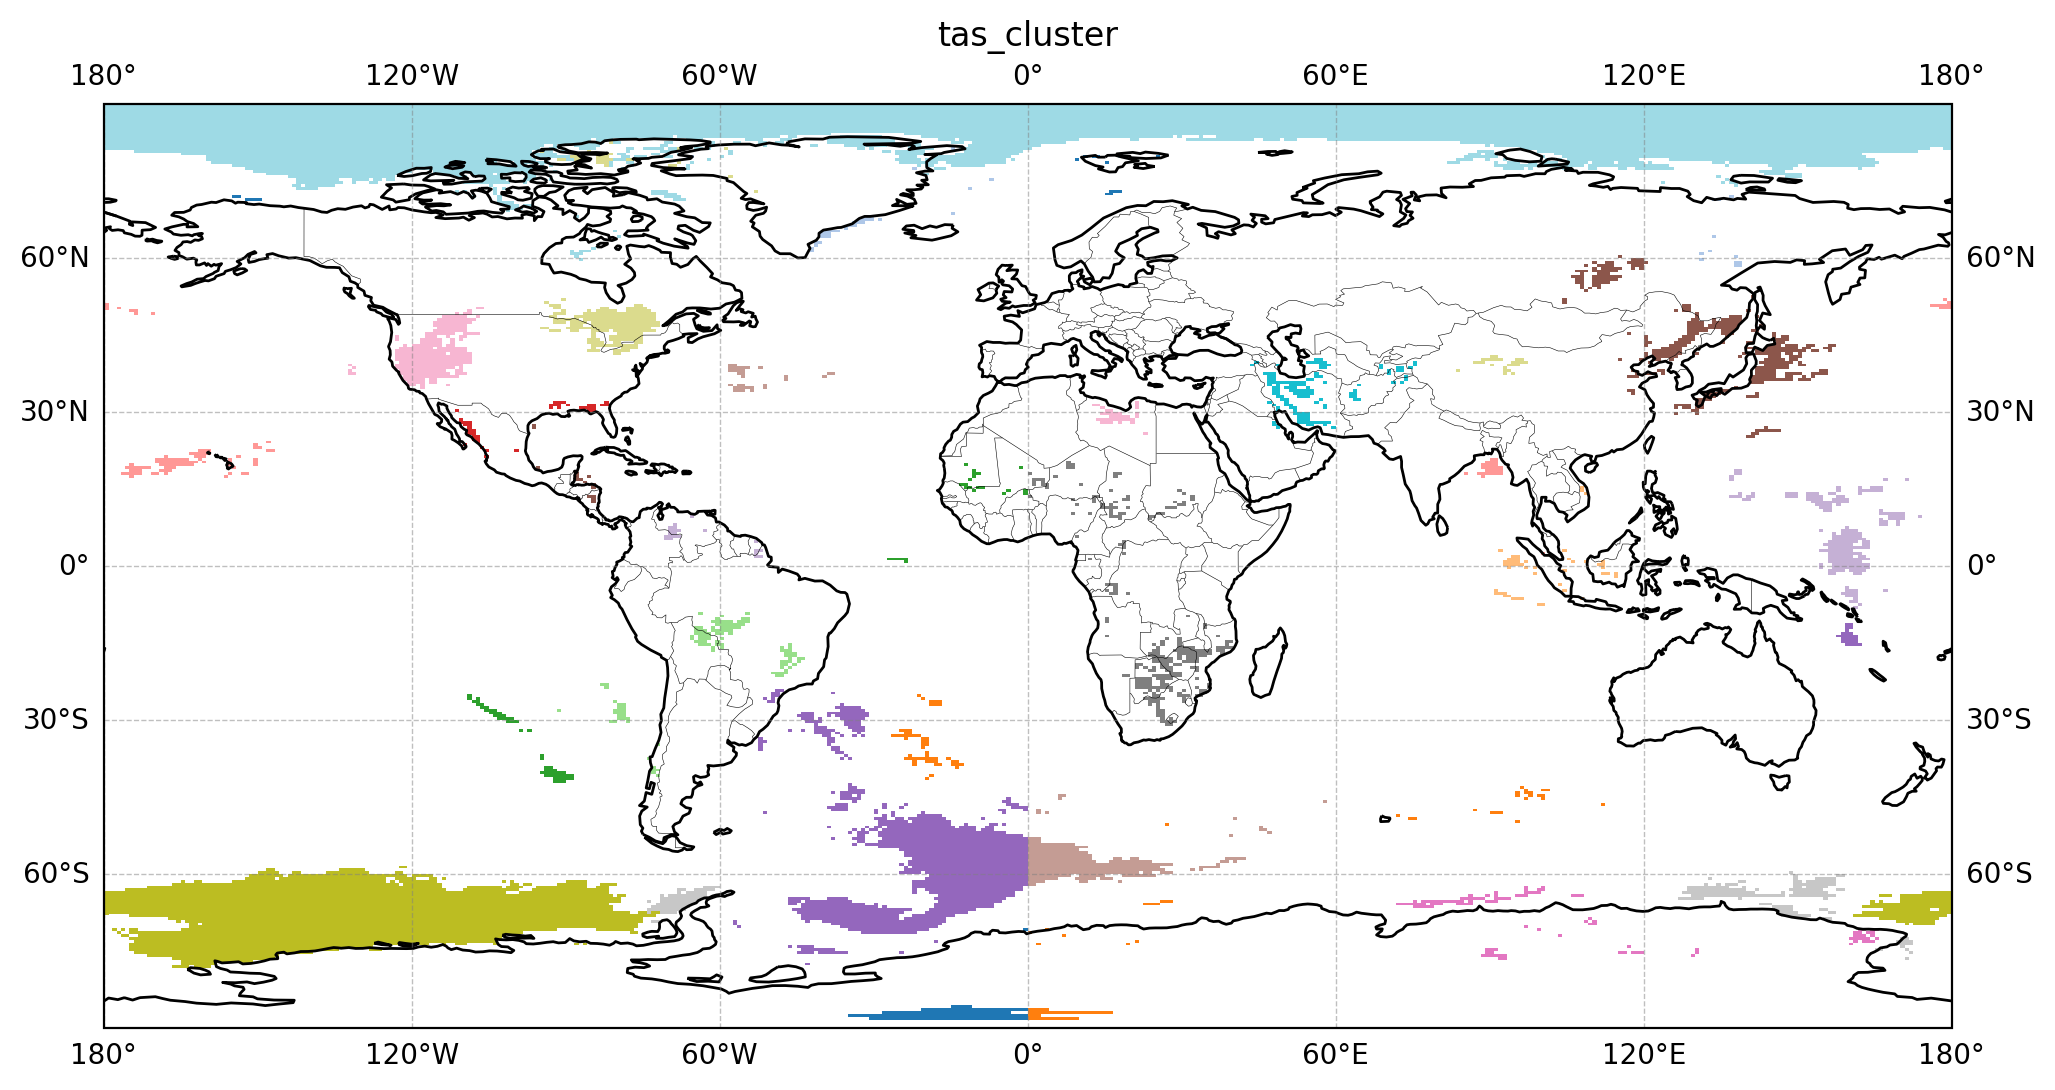

In [78]:
fig, ax = TOADPlotter(td).map_plots(linewidth=(1,.2))
TOADPlotter(td).plot_clusters_on_map("tas", ax=ax);

Here you see a current issue in clustering: HDBSCAN/DBSCAN uses euclidean distances, so clusters can't cross the 0° longitude line.